In [1]:
import pyarrow.parquet as pq

table = pq.read_table(
    r"C:\Users\StrucData 1\Downloads\1-Neris-20110810.binetflow.parquet\1-Neris-20110810.binetflow.parquet",
    read_dictionary=False
)

df = table.to_pandas(ignore_metadata=True)
df.reset_index(drop=True, inplace=True)


In [14]:
import pandas as pd
import numpy as np
import pyarrow as pa

print(f"Pandas version: {pd.__version__}")
print(f"NumPy version:  {np.__version__}")
print(f"PyArrow version: {pa.__version__}")

# This check provides a deeper look at your environment's health
pd.show_versions()

Pandas version: 2.3.3
NumPy version:  1.26.4
PyArrow version: 17.0.0

INSTALLED VERSIONS
------------------
commit                : 9c8bc3e55188c8aff37207a74f1dd144980b8874
python                : 3.11.0
python-bits           : 64
OS                    : Windows
OS-release            : 10
Version               : 10.0.26100
machine               : AMD64
processor             : Intel64 Family 6 Model 191 Stepping 2, GenuineIntel
byteorder             : little
LC_ALL                : None
LANG                  : None
LOCALE                : English_India.1252

pandas                : 2.3.3
numpy                 : 1.26.4
pytz                  : 2025.2
dateutil              : 2.9.0.post0
pip                   : 25.2
Cython                : None
sphinx                : None
IPython               : 8.30.0
adbc-driver-postgresql: None
adbc-driver-sqlite    : None
bs4                   : None
blosc                 : None
bottleneck            : None
dataframe-api-compat  : None
fastparquet     

In [11]:
df_sample = df.sample(10)
print(df_sample)



                 dur proto    dir      state  stos  dtos  tot_pkts  tot_bytes  \
765069   2021.606445   udp    <->        CON   0.0   0.0         4        276   
884376      0.206229   tcp     ->  FSPA_FSPA   0.0   0.0        38      29440   
572379      0.000532   udp    <->        CON   0.0   0.0         2        267   
562976      0.067040   udp    <->        CON   0.0   0.0         2        474   
1236867     0.169469   udp    <->        CON   0.0   0.0         2        523   
1316126     0.116350   udp    <->        CON   0.0   0.0         2        289   
1271333     0.000870   udp    <->        CON   0.0   0.0         2        564   
1478953     0.280122   udp    <->        CON   0.0   0.0         4        460   
1540193     0.303297   tcp     ->       S_RA   0.0   0.0         2        151   
1555191   920.912781   tcp     ->    SPA_SPA   0.0   0.0        71       6925   

         src_bytes                                   label  \
765069         156         flow=Background-UDP

In [38]:
def dur_bucket(d):
    if d < 0.01: return "dur_very_short"
    if d < 1: return "dur_short"
    if d < 100: return "dur_medium"
    return "dur_long"

def bytes_bucket(b):
    if b < 200: return "bytes_low"
    if b < 1000: return "bytes_medium"
    return "bytes_high"

def pkt_bucket(n):
    if n <= 2: return "pkt_low"
    if n <= 10: return "pkt_mid"
    return "pkt_high"

def byte_bucket(n):
    if n <= 300: return "bytes_low"
    if n <= 1000: return "bytes_mid"
    return "bytes_high"

In [1]:
import networkx as nx

G = nx.MultiDiGraph()

# Store labels externally (DO NOT put in KG)
flow_labels = {}

for idx, row in df_sample.iterrows():
    flow = f"flow_{idx}"

    # ---------- Bucketing ----------
    d_bucket = dur_bucket(row["dur"])
    pkt_b = pkt_bucket(row["tot_pkts"])
    byte_b = byte_bucket(row["tot_bytes"])
    vol_b = bytes_bucket(row["tot_bytes"])

    # ---------- Nodes ----------
    G.add_node(flow, type="flow")

    G.add_node(row["proto"], type="protocol")
    G.add_node(row["dir"], type="direction")
    G.add_node(row["state"], type="state")
    G.add_node(d_bucket, type="duration")
    G.add_node(pkt_b, type="pkt_bucket")
    G.add_node(byte_b, type="byte_bucket")
    G.add_node(vol_b, type="volume")
    G.add_node(row["Family"], type="family")

    # ---------- Flow → Attribute edges ----------
    G.add_edge(flow, row["proto"], relation="USES_PROTOCOL")
    G.add_edge(flow, row["dir"], relation="HAS_DIRECTION")
    G.add_edge(flow, row["state"], relation="HAS_STATE")
    G.add_edge(flow, d_bucket, relation="HAS_DURATION")
    G.add_edge(flow, pkt_b, relation="HAS_PKT_VOLUME")
    G.add_edge(flow, byte_b, relation="HAS_BYTE_VOLUME")
    G.add_edge(flow, vol_b, relation="HAS_TOTAL_VOLUME")
    G.add_edge(flow, row["Family"], relation="BELONGS_TO")

    # ---------- Attribute → Attribute edges (CRITICAL) ----------
    G.add_edge(row["proto"], row["state"], relation="PROTO_STATE")
    G.add_edge(row["state"], d_bucket, relation="STATE_DURATION")
    G.add_edge(d_bucket, vol_b, relation="DURATION_VOLUME")
    G.add_edge(pkt_b, byte_b, relation="PKT_BYTE_CORRELATION")

    # ---------- Store label externally ----------
    flow_labels[flow] = row["label"]


NameError: name 'df_sample' is not defined

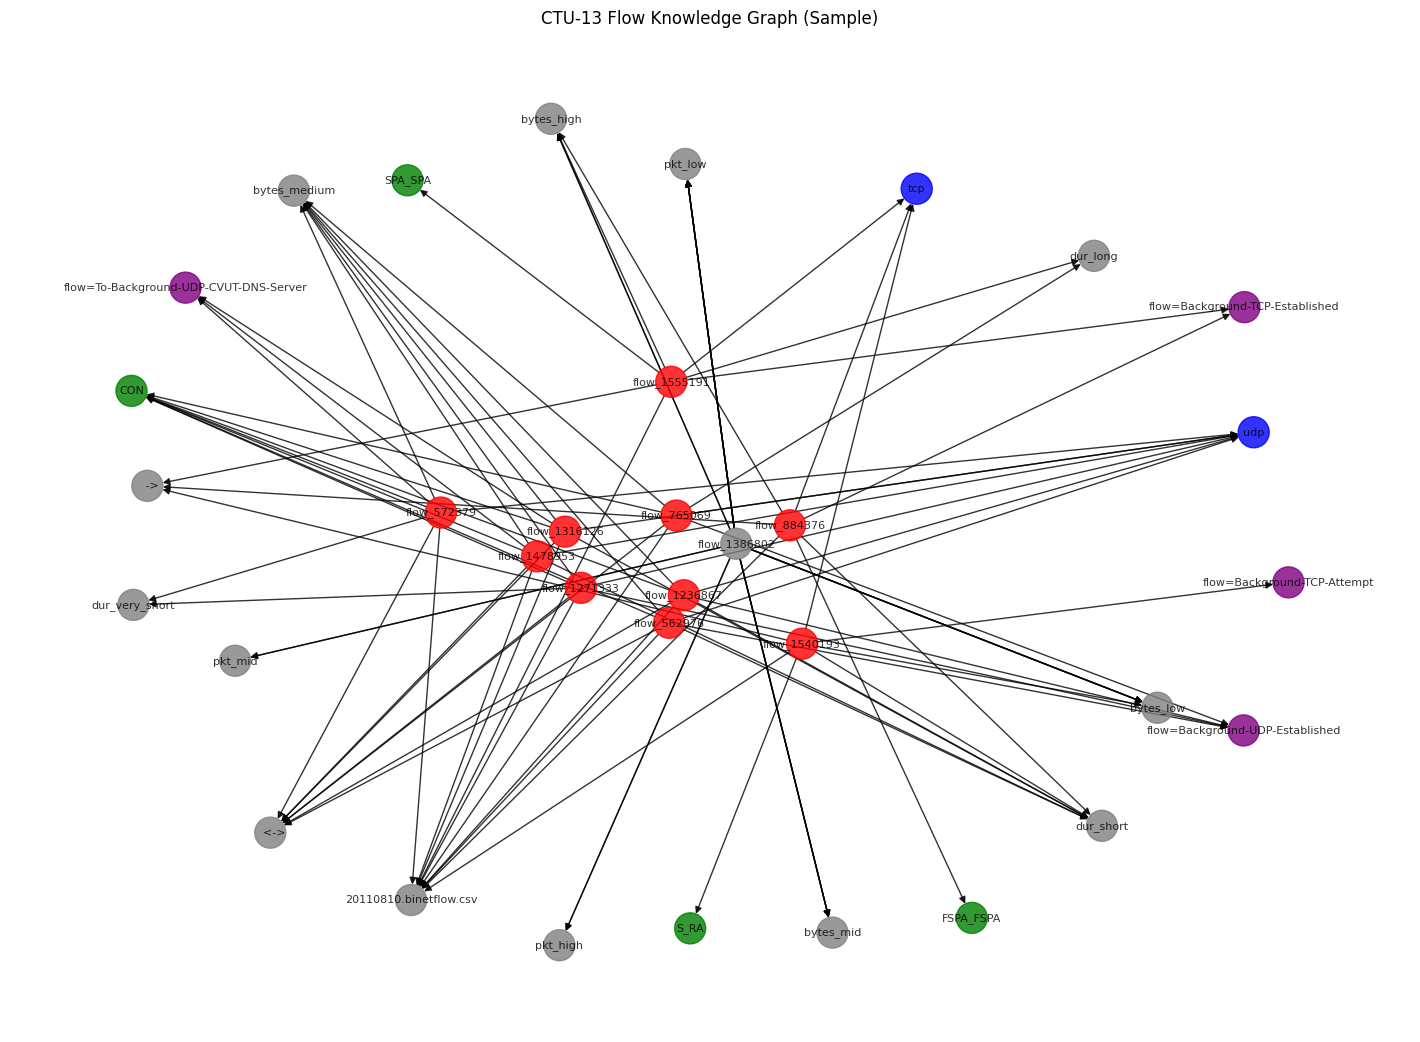

In [37]:
import matplotlib.pyplot as plt
import networkx as nx

plt.figure(figsize=(14, 10))

pos = nx.spring_layout(G, k=0.8, seed=42)

node_colors = []
for n in G.nodes():
    t = G.nodes[n].get("type", "")
    if t == "flow":
        node_colors.append("red")
    elif t == "protocol":
        node_colors.append("blue")
    elif t == "state":
        node_colors.append("green")
    elif t == "label":
        node_colors.append("purple")
    else:
        node_colors.append("gray")

nx.draw(
    G,
    pos,
    node_size=500,
    node_color=node_colors,
    with_labels=True,
    font_size=8,
    edge_color="black",
    alpha=0.8
)

plt.title("CTU-13 Flow Knowledge Graph (Sample)")
plt.show()


In [40]:
print("Nodes:", G.number_of_nodes())
print("Edges:", G.number_of_edges())


Nodes: 34
Edges: 90


In [20]:
neighbors_f1 = set(G.neighbors("flow_572379"))
neighbors_f2 = set(G.neighbors("flow_1316126"))

jaccard = len(neighbors_f1 & neighbors_f2) / len(neighbors_f1 | neighbors_f2)
print(jaccard)


0.75


In [49]:
from node2vec import Node2Vec

# Create Node2Vec model
node2vec = Node2Vec(
    G,
    dimensions=128,
    walk_length=30,
    num_walks=200,
    workers=1
)

# Train
model = node2vec.fit(window=10, min_count=1)

# Store embeddings in a dictionary
embeddings = {node: model.wv[node] for node in G.nodes()}


Generating walks (CPU: 1): 100%|██████████| 200/200 [00:00<00:00, 19980.01it/s]


In [50]:
flow_nodes = [n for n in G.nodes() if n.startswith("flow_")]
flow_nodes[:10]


['flow_765069',
 'flow_1386802',
 'flow_884376',
 'flow_572379',
 'flow_562976',
 'flow_1236867',
 'flow_1316126',
 'flow_1271333',
 'flow_1478953',
 'flow_1540193']

In [51]:
f1 = flow_nodes[0]
f2 = flow_nodes[1]


In [52]:
from sklearn.metrics.pairwise import cosine_similarity

sim = cosine_similarity(
    embeddings[f1].reshape(1, -1),
    embeddings[f2].reshape(1, -1)
)


print(f"Cosine similarity between {f1} and {f2}: {sim[0][0]:.4f}")



Cosine similarity between flow_765069 and flow_1386802: 0.0122


In [53]:
import random
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

def cos(u, v):
    return cosine_similarity(u.reshape(1,-1), v.reshape(1,-1))[0,0]


In [54]:
flow_nodes = [
    n for n, d in G.nodes(data=True)
    if d.get("type") == "flow"
]


In [55]:
def get_label(flow_id):
    idx = int(flow_id.replace("flow_", ""))
    return df_sample.loc[idx, "label"]


In [56]:
from sklearn.metrics.pairwise import cosine_similarity
import random
import numpy as np

def cos(a, b):
    return cosine_similarity([a], [b])[0][0]

same, diff = [], []

for _ in range(200):
    f1, f2 = random.sample(flow_nodes, 2)

    l1 = get_label(f1)
    l2 = get_label(f2)

    s = cos(embeddings[f1], embeddings[f2])

    if l1 == l2:
        same.append(s)
    else:
        diff.append(s)

print("Avg SAME label similarity:", np.mean(same))
print("Avg DIFF label similarity:", np.mean(diff))


Avg SAME label similarity: 0.041579388
Avg DIFF label similarity: 0.04197807
